<b>This script requires astropy 3.0dev</b>

<h2>Testing normalization with units in a compound model setting</h2>

In these experiments, we run the fitters with the model components initialized to their default values provided by astropy, not to the data at hand as is currently done in specviz. 

This is done using Thomas Robitaille's suggestion of using the units machinery in astropy to perform the fit on normalized data. In this way, all fitters will see a data set that exists in the range [-1:1] in both X and Y coordinates.

<b>Result: </b> these experiments confirm what we have found before, that of the three fitters offered in astropy.modeling, L-M is the most reliable. 

The experiments also suggest that the normalization technique is a viable alternative to providing initial guesses based on the actual data at hand. However, this can be said for now only for simple cases as the one tested here, where one component dominates the model. In more complex models with many spectral components, this approach of  normalizing the data to [-1:1] remains to be tested yet.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.gcf().set_size_inches(8.,4.)

from astropy import units as u
from astropy.modeling import models, fitting


# This is basically Thomas Robitaille's example 
# normalization/fitting code, cast in the form 
# of a function.
    
def perform_fit(fitter, model, wave, flux):
    # Define custom units for x and y
    ux1 = u.def_unit('ux1')
    uy1 = u.def_unit('uy1')
    w1 = wave * ux1
    f1 = flux * uy1

    # Determine maximum values in each direction
    wmax = np.max(np.abs(w1.value))
    fmax = np.max(np.abs(f1.value))

    # Define new units so that in this system, the data is always in the range
    # [-1:1] in both directions and convert data to that frame.
    ux2 = u.Unit(wmax * w1.unit)
    uy2 = u.Unit(fmax * f1.unit)
    w2 = w1.to(ux2)
    f2 = f1.to(uy2)

    # Strip away the units for the fitting
    w3 = w2.value
    f3 = f2.value

    # Run the fitting
    m3 = fitter(model, w3, f3, maxiter=1000)

    if 'message' in fitter.fit_info:
        print(fitter.fit_info['message'])

    # Add units to the parameters for the data that was fit, and then transform
    # the parameters to the original units of the data
    m2 = m3.with_units_from_data(x=w2, y=f2)
    m1 = m2.without_units_for_data(x=w1, y=f1)

    return m1

In [2]:
# Run one test: for a given fitter and model, fit two data sets comprised of
# a Gaussian and a linear spectral components. Do the fit a number of times 
# with different realizations of the noise, so as to probe the fitter's 
# sensitivity to noise.

def test(fitter, model, w, f1, f2, scale, title):
    result_1 = []
    result_2 = []
    colors = ['-g','-r','-b','-y','-m']
    
    for k in range(len(colors)):
        f1_n = f1 + scale / 10 * np.random.normal(0, 1, len(wave))
        f2_n = f2 + scale / 10 * np.random.normal(0, 1, len(wave))

        result_1.append(perform_fit(fitter, model, w, f1_n))
        result_2.append(perform_fit(fitter, model, w, f2_n))

    # note that, to avoid clutter, this will plot just one of the 
    # several data sets that contain the same spectral components 
    # but different noise realizations.
    plt.figure(figsize=(10, 3))
    plt.subplot(121)
    plt.plot(w, f1_n, 'k.')
    for result, color in zip(result_1, colors):
        plt.plot(w, result(w), color)
    plt.title(title + " - data set 1")    
    plt.subplot(122)
    plt.plot(w, f2_n, 'k.')
    for result, color in zip(result_2, colors):
        plt.plot(w, result(w), color)
    plt.plot(w, result_2[0](w), 'g-')
    plt.title(title + " - data set 2")    

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
The relative error between two consecutive iterates is at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
Optimization terminated succes

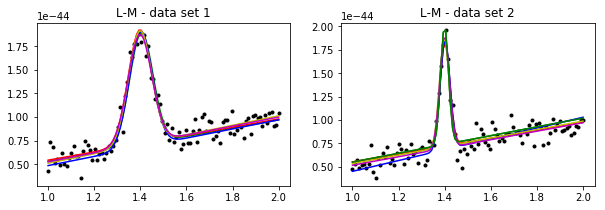

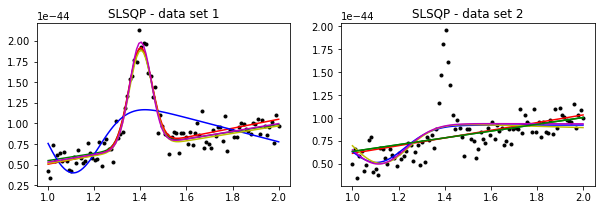

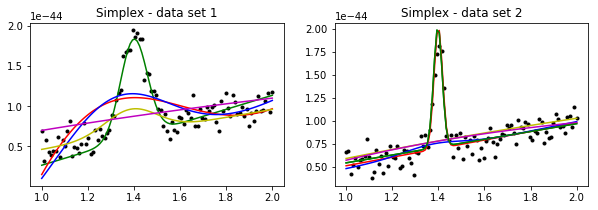

In [3]:
# Scale factor to make flux values look realistic (e.g in flam units)
SCALE = 1e-44

# Build two data sets with simulated Gaussian + linear components. The 
# data sets are identical except for the width of the Gaussian component: 
# data set 2 has a narrower Gaussian. 
#
# This is noiseless data, the test function adds actual noise realizations 
# to these data.
width1 = 0.05
width2 = 0.02
wave = np.linspace(1, 2, 100)
f1 = (1.2 * SCALE * np.exp(-0.5 * (wave - 1.4)**2 / width1**2) +
      SCALE * (0.01 + 0.5 * wave))
f2 = (1.2 * SCALE * np.exp(-0.5 * (wave - 1.4)**2 / width2**2) +
      SCALE * (0.01 + 0.5 * wave))

model = models.Gaussian1D() + models.Linear1D()

# Fit and plot.
fitter = fitting.LevMarLSQFitter()
test(fitter, model, wave, f1, f2, SCALE, "L-M")

fitter = fitting.SLSQPLSQFitter()
test(fitter, model, wave, f1, f2, SCALE, "SLSQP")

fitter = fitting.SimplexLSQFitter()
test(fitter, model, wave, f1, f2, SCALE, "Simplex")